## Домашнее задание №1 (Золотарев Антон, ИАД-1)

В этом домашнем задании вы познакомитесь с pytorch сами и сможете попрактиковаться в его применении. 

#### План:

1. Простейшие операции в pytorch
2. Пишем Adam и применяем его к ручной модели
3. Обучаем свою первую нейросеть (не обучил)

In [5]:
import os
import sys
import math
import torch
import random
import numpy as np
from tqdm import tqdm
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt


### Простейшие операции на pytorch (2 балла)

**Task**: Cоздайте два случайных тензора (двумерных, не квадратных):

In [6]:
x = torch.randn(4, 3)
y = torch.randn(3, 4) 

**Task**: Умножьте их друг на друга, результат запишите в третий тензор без использования оператора `=`, для создания третьего тензора предлагается использовать `torch.empty`:

In [7]:
z = torch.empty(4,4)
torch.matmul(x, y, out=z)
z

tensor([[-0.7200,  0.8892, -0.5722,  1.2333],
        [ 0.9728, -0.8438, -3.5252, -0.2889],
        [ 1.0432, -2.4391, -1.4683, -1.4218],
        [-0.6709,  0.1479,  3.3904, -0.2062]])

**Task**: Реализуйте ReLU использую только pytorch, примените его к тензору `x` (запрещено использование модулей torch.nn и его подмодулей, а также функции torch.relu)

In [8]:
def relu_forward(x):
      return torch.max(torch.zeros_like(x), x)

assert torch.all(F.relu(x) == relu_forward(x))

**Task**: Сделайте тоже самое c ELU (запрещено использование модулей torch.nn и его подмодулей):

In [9]:
def elu_forward(x, alpha=1):
    return torch.min(torch.zeros_like(x), alpha*(torch.exp(x)-1))+torch.max(torch.zeros_like(x), x)
    pass

assert torch.allclose(
    F.elu(x),
    elu_forward(x), 
    1e-4
)

**Task**: LeakyReLU (запрещено использование модулей torch.nn и его подмодулей):

In [10]:
def lrelu_forward(x, alpha):
    return alpha*torch.min(torch.zeros_like(x), x)+torch.max(torch.zeros_like(x), x)
    pass

assert torch.all(F.leaky_relu(x, 0.01) == lrelu_forward(x, 0.01))

**Task**: Теперь перейдем к немного более современным функциям активаций, например Mish, напомним как она выглядит:

$$x * tanh(ln(1+e^x))$$

Также вспомним, что за зверь такой этот ваш tanh:

$$ tanh(x) = \frac {e^{2x}-1}{e^{2x}+1}$$
(запрещено использование модулей torch.nn и его подмодулей)

In [11]:
def mish(x):
    return x*(torch.exp(2*torch.log(1+torch.exp(x)))-1)/(torch.exp(2*torch.log(1+torch.exp(x)))+1)
    pass

In [12]:
assert torch.allclose(
    mish(torch.tensor([1, 1, 1], dtype=torch.float32)), 
    torch.tensor([0.8651, 0.8651, 0.8651]), 
    atol=1e-4
)

assert torch.allclose(
    mish(torch.tensor([0.6376, 0.4021, 0.6656, 0.3726], dtype=torch.float64)), 
    torch.tensor([0.5014, 0.2908, 0.5280, 0.2663], dtype=torch.float64), 
    atol=1e-4
)

**Task**: Теперь реализуем swish, напомним как она выглядит:

$$x * \sigma(x) = \frac{x}{1+e^{-x}}$$

(запрещено использование модулей torch.nn и его подмодулей)
Сначала я думал, что вы хотите от меня стандартное отклонение, потом посмотрел на примеры, на которых надо прогнать написанную функцию и осознал, что надо копать глубже...

In [13]:
def swish(x):
    return x/(1+torch.exp(-x))
    pass

In [14]:
assert torch.allclose(
    swish(torch.tensor([1, 1, 1], dtype=torch.float32)), 
    torch.tensor([0.7311, 0.7311, 0.7311]), 
    atol=1e-4
)

assert torch.allclose(
    swish(torch.tensor([0.6376, 0.4021, 0.6656, 0.3726], dtype=torch.float64)), 
    torch.tensor([0.4171, 0.2409, 0.4396, 0.2206], dtype=torch.float64), 
    atol=1e-4
)

### Пишем Adam и применяем его к логистической регрессии (4 балла)


В данной секции вам нужно сделать две вещи: 

1. Написать свой собственный оптимизатор подобно тому, который мы писали на семинаре
2. Обучить логистическую регрессию побатчево на картинках из датасета 


#### Adam


$$
\begin{eqnarray}
g &=& \frac{1}{m}\nabla_w \sum_i L(f(x_{i};w), y_{i}) \\
m &=& \beta_1 m + (1 - \beta_1) g \\
v &=& \beta_2 v + (1 - \beta_2) diag(gg^{T}) \\
\hat{m} &=& \frac{m}{1 - \beta_1^{t}} \\
\hat{v} &=& \frac{v}{1 - \beta_2^{t}} \\
w &=& w - \frac{\eta}{\sqrt{\hat{v} + \epsilon}} \odot \hat{m}
\end{eqnarray}
$$

In [15]:
# абстрактный класс, не обращайте внимания
from torch.optim import Optimizer


class InClassOptimizer(Optimizer):
    def step(self):
        """Perform single optimization step."""
        with torch.no_grad(): # выключим градиенты
            for group in self.param_groups:
                self._group_step(group)

    def _group_step(self, group):
        # group ~ dict[str, ...]
        """
        Private helper function to perform
        single optimization step on model parameters.
        """
        raise NotImplementedError()

**Task**: Напишите свою реализацию Adam:

In [48]:
class Adam(InClassOptimizer):
    def __init__(self, params, lr=0.001, eps=1e-13, beta_1=0.9, beta_2=0.999):
        defaults = dict(lr=lr, eps=eps, beta_1=beta_1, beta_2=beta_2)
        super().__init__(params, defaults)

    def _group_step(self, group):
        # One group contains information about values passed in init
        # and model parameters to update
        lr = group['lr']
        eps = group['eps']
        beta_1 = group['beta_1']
        beta_2 = group['beta_2']
        step = 0
        for param in filter(lambda x: x.grad is not None, group['params']):
            self._init_adam_buffer(param)
            g_param = param.grad
            buffer_m, buffer_u = self._get_adam_buffer(param)
            buffer_m = buffer_m * beta_1 + (1 - beta_1) * g_param
            buffer_u = beta_2 * buffer_u + (1-beta_2) * (g_param**2)
            step += 1
            buffer_m = buffer_m / ( 1 - beta_1 ** step ) 
            buffer_u = buffer_u / (1 - beta_2 ** step)
            buffer_m = buffer_m - (lr / torch.sqrt(buffer_u+eps)) * buffer_m
            param.add_(buffer_m, alpha=-lr)

    def _get_adam_buffer(self, param):
        """
        Get accumulated gradients for Adam.

        Parameters
        ----------
        param : `torch.Tensor`, required
            Model parameter to get accumulated gradeints for Adagrad.

        Returns
        -------
        Accumulated Adam gradients for parameter.
        """
        param_state = self.state[param]
        return param_state['adam_buffer_m'], param_state['adam_buffer_u']

    def _init_adam_buffer(self, param):
        """
        Initialize accumulated gradeints for adam.

        Parameters
        ----------
        param : `torch.Tensor`, required
            Model parameter to get accumulated gradeints for adam.
        """
        param_state = self.state[param]
        if 'adam_buffer_m' not in param_state:
            param_state['adam_buffer_m'] = torch.zeros_like(param)
        if 'adam_buffer_u' not in param_state:
            param_state['adam_buffer_u'] = torch.zeros_like(param)


**Task**: Создайте параметры для обучения логистической регрессии, сделаем Xavier ициализацию, которая выглядит следующим образом: 

$$w \sim U[-\frac{\sqrt{6}}{\sqrt{n_{in} + n_{out}}}, \frac{\sqrt{6}}{\sqrt{n_{in} + n_{out}}}]$$

где: 

* $n_{in}$ -- размер входа (в нейронах) 
* $n_{out}$ -- размер выхода (в нейронах)

Подумайте над выбором $n_{in}$ и $n_{out}$ самостоятельно. 

In [49]:
from torch.distributions.uniform import Uniform
n_in = 784 #28*28
n_out = 10

low = -np.sqrt(6) / np.sqrt(n_in + n_out)
up = -low

weights = torch.autograd.Variable(torch.FloatTensor(n_in, n_out).uniform_(low, up), requires_grad=True)
intercept = torch.autograd.Variable(torch.FloatTensor(1, n_out).uniform_(low, up), requires_grad=True)

In [50]:
weights

tensor([[-0.0433,  0.0204, -0.0697,  ...,  0.0253, -0.0828,  0.0806],
        [ 0.0832,  0.0469, -0.0288,  ..., -0.0136,  0.0620, -0.0582],
        [-0.0504,  0.0060,  0.0660,  ...,  0.0336,  0.0240,  0.0211],
        ...,
        [ 0.0007,  0.0181,  0.0336,  ...,  0.0790,  0.0128,  0.0044],
        [ 0.0838,  0.0794,  0.0138,  ...,  0.0327,  0.0642, -0.0583],
        [-0.0155,  0.0499,  0.0431,  ..., -0.0087, -0.0027,  0.0200]],
       requires_grad=True)

In [51]:
optimizer = Adam([weights, intercept])
loss = nn.CrossEntropyLoss()

Загрузим данные и создадим даталоадеры:

In [67]:
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

fashion_mnist_train = torchvision.datasets.FashionMNIST(
    './data',
    download=True,
    transform=transforms.Compose([transforms.ToTensor()])
)
train_dataloader = DataLoader(fashion_mnist_train, batch_size=8*8, shuffle=True, num_workers=1)

fashion_mnist_eval = torchvision.datasets.FashionMNIST(
    './data',
    train=False,
    download=True,
    transform=transforms.Compose([transforms.ToTensor()])
)

eval_dataloader = DataLoader(
                            fashion_mnist_eval, batch_size=8*8, num_workers=1
                            )

Напишите функцию для тренировки логистической регрессии, она должна: 
    * Делать предсказания 
    * Считать лосс 
    * Подсчитывать градиенты
    * Делать шаг оптимизации
    * Обнулять посчитанные градиенты
    * Считать метрики 
    * Возвращать полученные метрики
    
После этого предусмотрите возможность визуализировать метрики, чтобы нарисовать картинки, а именно от вас требуется визуализировать: 

    * Зависимость лосса от количества итераций
    * Зависимость доли правильных ответов от количества итераций

In [68]:
def train_logistic_regression(weights, intercept, batch, loss, optimizer):
    image, label = batch
    output = torch.matmul(image.view(-1, 784), weights) + intercept
    batch_loss = loss(output, label)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    smth, predicted = torch.max(output, 1)
    accuracy = (predicted == label).sum().item() / len(label)
    return batch_loss, accuracy

In [69]:
#функция подсчёта метрик, делали что-то такое на семинаре 4 (как и всю задачу в принципе)
def calc_metrics(weights, intercept, eval_dataloader, loss):
    val_loss = []
    val_acc = []
    with torch.no_grad():
      for batch in eval_dataloader:
          img, label = batch
          output = torch.matmul(img.view(-1, 784), weights) + intercept
          batch_loss = loss(output, label).detach().numpy()
          _, predicted = torch.max(output, 1)
          accuracy = (predicted == label).sum().item() / len(label)
          val_loss.append(batch_loss)
          val_acc.append(accuracy)
      return np.sum(val_loss) / len(eval_dataloader), np.sum(val_acc) / len(eval_dataloader)

In [80]:
len(epoch_loss)

92862

In [71]:
loss2, acc, epoch_number, val_loss, val_acc, epoch_loss, epoch_acc = [], [], [], [], [], [], []
for epoch in range(1, 100):
    for batch in train_dataloader:
        metrics = train_logistic_regression(weights, intercept, batch, loss, optimizer)
        loss2.append(metrics[0].detach().numpy())
        acc.append(metrics[1])
        epoch_number.append(epoch)
    loss3 = np.array(loss2)
    accuracy = np.array(acc)
    epoch_num = np.array(epoch_number)

    avg_acc = np.sum(accuracy[epoch_num == epoch]) / len(train_dataloader)
    avg_loss = np.sum(loss3[epoch_num == epoch]) / len(train_dataloader)

    val_loss, val_acc = calc_metrics(weights, intercept, eval_dataloader, loss)
    val_acc += [val_acc]*len(train_dataloader)
    val_loss += [val_loss]*len(train_dataloader)

    epoch_acc += [avg_acc]*len(train_dataloader)
    epoch_loss += [avg_loss]*len(train_dataloader)

    print('Epoch', epoch, 
          ', loss on train', round(avg_loss, 3), ', validation loss', round(val_loss[0], 3),
          ', accuracy on train',  round(avg_acc, 3), ', validation accuracy', round(val_acc[0], 3))

Epoch 1 , loss on train 0.733 , validation loss 1.49 , accuracy on train 0.77 , validation accuracy 1.522
Epoch 2 , loss on train 0.72 , validation loss 1.466 , accuracy on train 0.774 , validation accuracy 1.528
Epoch 3 , loss on train 0.708 , validation loss 1.444 , accuracy on train 0.777 , validation accuracy 1.534
Epoch 4 , loss on train 0.697 , validation loss 1.425 , accuracy on train 0.78 , validation accuracy 1.542
Epoch 5 , loss on train 0.688 , validation loss 1.408 , accuracy on train 0.783 , validation accuracy 1.547
Epoch 6 , loss on train 0.679 , validation loss 1.391 , accuracy on train 0.786 , validation accuracy 1.55
Epoch 7 , loss on train 0.671 , validation loss 1.376 , accuracy on train 0.789 , validation accuracy 1.557
Epoch 8 , loss on train 0.664 , validation loss 1.363 , accuracy on train 0.79 , validation accuracy 1.559
Epoch 9 , loss on train 0.657 , validation loss 1.35 , accuracy on train 0.793 , validation accuracy 1.563
Epoch 10 , loss on train 0.651 , va

Кажется, пора защищать докторскую по эвристике, которая выдаёт точность больше 1... Все остальные метрики, кажется, работают относительно нормально и выдают всё достаточно правдоподобно, с каждой итерацией всё более приближаясь к оптимальным значениям. Есть ощущение, что случайно где-то дважды считаю валидационные метрики, из-за чего их значения везде примерно в 2 раза больше тренировочных, поэтому при визуализации буду использовать деление на 2 ( как минимум чтобы точность не превосходила 1).

#### Вопросы к секции: 

* Своими словами и без математики объясните благодаря чему Adam дает несмещенную оценку на квадрат градиента
* Когда модель начала переобучаться? Как вы это поняли? Сделайте визуализацию и докажите свою точку зрения.

Adam даёт несмещённую оценку на квадрат градиента постольку, поскольку на каждой последующей итерации мы учитываем все предыдущие результаты и последний полученный, рассчитывая средневзвешенное от этой штуки. Чем больше раз мы попытались адекватно предсказать наше наблюдение, тем больше вероятность, что в среднем мы будем близки к правде. Ну и то, что отнимается от вектора весов на каждом шаге, кажется чем-то нормированным (вектор m как мат ожидание, вектор u как СКО).

Модель начинает переобучаться примерно на никакой итерации, поскольку на каждой последующей эпохе валидационные метрики улучшают свою качество, loss -> 0, accuracy -> $\infty$. Но вероятнее всего моя модель имеет ряд ошибок, поскольку её точность больше 1, она должна была начать переобучаться ранее, когда пришла бы к локальному оптимуму. Приведём визуализацию:

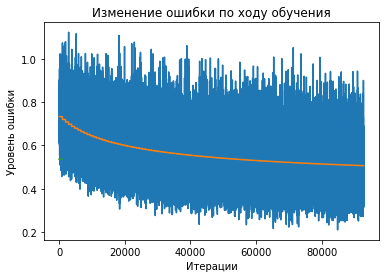

In [86]:
x_arr = np.arange(len(loss3))
plt.plot(x_arr, loss3)
plt.plot(x_arr, epoch_loss) 
plt.plot(np.arange(len(val_loss)), val_loss/2)
plt.title('Изменение ошибки по ходу обучения')
plt.xlabel('Итерации')
plt.ylabel('Уровень ошибки')

plt.show()

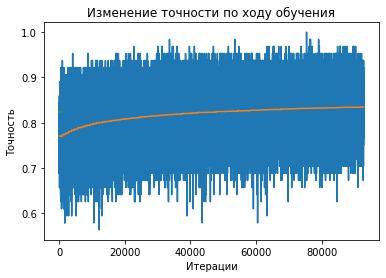

In [88]:
plt.plot(x_arr, accuracy)
plt.plot(x_arr, epoch_acc)
plt.plot(np.arange(len(val_acc)), val_acc/2)
plt.title('Изменение точности по ходу обучения')
plt.xlabel('Итерации')
plt.ylabel('Точность')

plt.show()

### Моя первая нейросеть (4 балла) - не сделал, не смотрите

В данной секции вам нужно сделать следующие вещи: 

* Реализовать три разных архитектуры нейросетей. Эти архитектуры должны принципиально отличаться друг от друга. Разрешается одной из архитекур брать полностью полносвязную модель. Остальные две должны быть сверточными и сильно отличаться друг от друга. К примеру, одна из таких архитектур может быть VGG подобная сеть, а другая ResNet подобная архитектура. 

* Написать цикл для обучения которым можно обучать все три модели без изменений кода

* Попробовать каждую модель с двумя оптимизаторами: RMSprop и SGD with momentum

* Визуализировать результаты перфоманса каждой модели (две метрики минимум для каждого сетапа, например, лосс и долю правильных ответов). В данном пункте мы ждем от вас визуализацию зависимости метрики от номера итерации обучения.

* Сделать выводы какие были модели были лучше и как вы думаете почему?

In [ ]:
def train_model(model, dataloader, optimizer):
    pass 

In [ ]:
class FirstModel(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        pass

    def forward(self, x):
        pass

In [ ]:
second_model = nn.Sequential(
    # your code here
)

In [ ]:
third_model = torch.nn.ModuleDict({
    # your code here
})

In [ ]:
# train and visualize and write summary down there